In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
from src.dm import DataModule
from matplotlib import pyplot as plt
from src.models.unet import UNet
import torch

In [34]:
dm = DataModule(batch_size=4, months=["April"], s1_bands=None)
dm.setup()

train: 8689
test: 8689


In [35]:
x, labels = next(iter(dm.train_dataloader()))
s1s, s2s = x
if s1s is not None:
    print(s1s.shape, s1s.max(), s1s.min(), s1s.dtype)
if s2s is not None:
    print(s2s.shape, s2s.max(), s2s.min(), s2s.dtype)
print(labels.shape, labels.max(), labels.min(), labels.dtype)

torch.Size([4, 1, 3, 256, 256]) tensor(1.) tensor(0.) torch.float32
torch.Size([4, 256, 256]) tensor(0.2225) tensor(0.) torch.float32


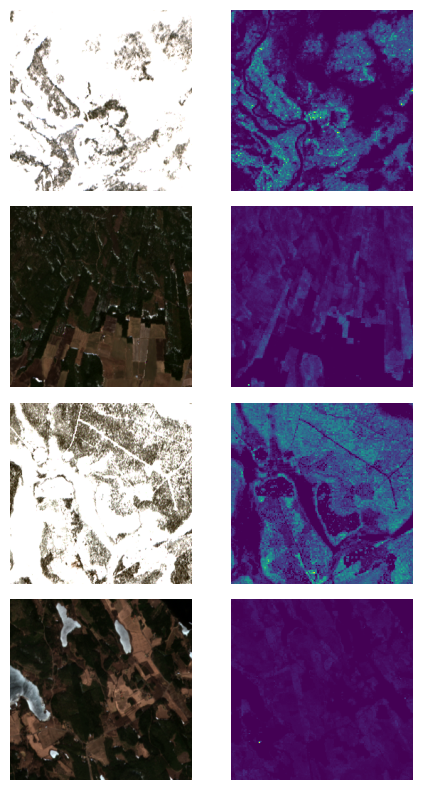

In [36]:
x, labels = next(iter(dm.train_dataloader()))
_, s2s = x
fig = plt.figure(figsize=(5, 2*dm.batch_size))
for i in range(dm.batch_size):
    ax = plt.subplot(dm.batch_size, 2, 2*i+1)
    ax.imshow(s2s[i][0].permute(1, 2, 0))
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 2, 2*i+2)
    ax.imshow(labels[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [39]:
hparams = {
    'encoder': 'resnet18',
    'pretrained': 'imagenet',
    'in_channels': 3
}

model = UNet(hparams)

outputs = model(None, s2s)
outputs.shape

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

torch.Size([4, 256, 256])

In [41]:
import pytorch_lightning as pl

dm = DataModule(batch_size=1, months=['April'], s1_bands=None, num_workers=4)

hparams = {
	'encoder': 'resnet18',
	'pretrained': 'imagenet',
	'in_channels': 3,
	'optimizer': 'Adam',
	'optimizer_params': {
		'lr': 1e-3
	},
}

module = UNet(hparams)

trainer = pl.Trainer(
	gpus=1,
	precision=16,
	overfit_batches=1,
	max_epochs=500,
	logger=None,
	enable_checkpointing=False,
)

trainer.fit(module, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | unet | Unet | 14.3 M
------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
28.656    Total estimated model params size (MB)


train: 8689
test: 8689


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:471: UserWarning: You requested to overfit but enabled training dataloader shuffling. We are turning off the training dataloader shuffling for you.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

In [42]:
import pytorch_lightning as pl

dm = DataModule(batch_size=4, months=['April'], s1_bands=None, num_workers=4)

hparams = {
	'encoder': 'resnet18',
	'pretrained': 'imagenet',
	'in_channels': 3,
	'optimizer': 'Adam',
	'optimizer_params': {
		'lr': 1e-3
	},
}

module = UNet(hparams)

trainer = pl.Trainer(
	gpus=1,
	precision=16,
	overfit_batches=1,
	max_epochs=1000,
	logger=None,
	enable_checkpointing=False,
)

trainer.fit(module, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | unet | Unet | 14.3 M
------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
28.656    Total estimated model params size (MB)


train: 8689
test: 8689


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:471: UserWarning: You requested to overfit but enabled training dataloader shuffling. We are turning off the training dataloader shuffling for you.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

In [46]:
x, labels = next(iter(dm.train_dataloader(shuffle=False)))
s1s, s2s = x
preds = module.predict(x)
preds.shape

torch.Size([4, 256, 256])

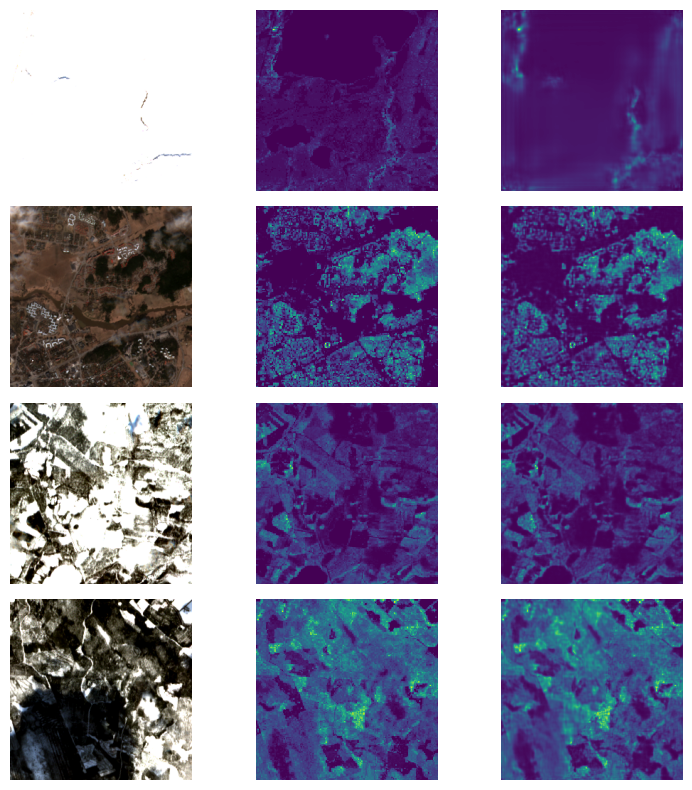

In [52]:
fig = plt.figure(figsize=(8, 2*dm.batch_size))
for i in range(dm.batch_size):
    ax = plt.subplot(dm.batch_size, 3, 3*i+1)
    ax.imshow(s2s[i][0].permute(1, 2, 0))
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 3, 3*i+2)
    ax.imshow(labels[i])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 3, 3*i+3)
    ax.imshow(preds[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [54]:
dm = DataModule(batch_size=32, months=['April'], s1_bands=None, num_workers=2)

hparams = {
	'encoder': 'resnet18',
	'pretrained': 'imagenet',
	'in_channels': 3,
	'optimizer': 'Adam',
	'optimizer_params': {
		'lr': 1e-3
	},
}

module = UNet(hparams)

trainer = pl.Trainer(
	gpus=1,
	precision=16,
	max_epochs=50,
	logger=None,
	enable_checkpointing=True,
)

trainer.fit(module, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | unet | Unet | 14.3 M
------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
28.656    Total estimated model params size (MB)


train: 8689
test: 8689


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:378: UserWarning: One of given dataloaders is None and it will be skipped.
  rank_zero_warn("One of given dataloaders is None and it will be skipped.")
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

RuntimeError: DataLoader worker (pid(s) 177, 181) exited unexpectedly